In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from PIL import Image
import sys
import os
from scipy import signal
import glob
import scipy

### Lucas-Kanade Algorithm
- 이미지 간의 optical flow를 계산하기 위해 x,y 방향의 gradients를 사용하여 벡터에서 최소 제곱을 찾고, 계산된 흐름을 사용하여 비디오에서 개체를 감지, 분할 및 추적을 함.
- input : grayscale과 window size의 두 이미지
- intensity gradients를 계산하기 위해 x,y,t 정의
- SVD 분해를 사용하여 각 창 내의 벡터(u,v) 계산

In [22]:
# optical flow 계산
def optical_flow(I1g, I2g, window_size, tau=1e-2):
    #Define our kernels to calculate gradients
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    
    # Implementing Lucas Kanade
    # For each point, we calculate I_x, I_y, I_t by conv2d
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode='same') + \
        scipy.signal.convolve2d(I1g, -kernel_t, boundary='symm', mode='same')
    
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    
    # For each window calculate the vectors [u,v], within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            
            A = [ [np.sum(Ix*Ix),np.sum(Ix*Iy)], [np.sum(Iy*Ix), np.sum(Iy*Iy)] ]
            A = np.array(A)
    
            b = [-np.sum(Ix*It), -np.sum(Iy*It)]
            b = np.array(b)
            
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            U,D,V_T = np.linalg.svd(A.T.dot(A))
            if np.min(D) < tau:
                u[i,j]=0
                v[i,j]=0                
            
            else:
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)
                
    return [u,v]

In [23]:
img1 = cv2.imread('/content/drive/MyDrive/Optical-Flow/data/Dumptruck/frame10.png')
img2 = cv2.imread('/content/drive/MyDrive/Optical-Flow/data/Dumptruck/frame11.png')
img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

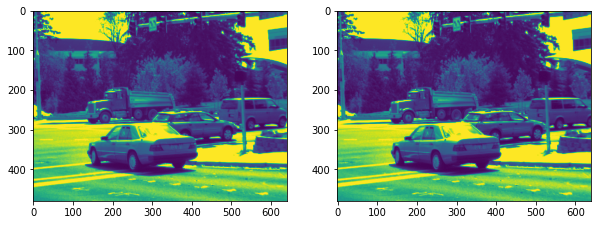

In [24]:
# 이동이 있는 두 이미지 확인
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(img1g)
f.add_subplot(1,2, 2)
plt.imshow(img2g)
plt.show()

In [25]:
# Lucas-Kanade 알고리즘을 구현하는 함수를 사용하여 두 이미지 사이의 흐름을 계산
u1,v1 = optical_flow(img1g, img2g, 15)

In [26]:
# 1) (u,v) 벡터 시각화
# u와 v사이의 크기와 각도 플로팅
def plot_vectors(im1,im2,u,v,fig_size=(10,10),arrow_thres=0.02):
    
    fig = plt.figure(figsize=fig_size)
    
    # Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("First Image")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Second Image")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U Vector")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V Vector")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='gray')
    ax.set_title("Magnitude: U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("Angle: arc(v/u)")
    ax.axis('off')
    
    plt.show()
    
    return None

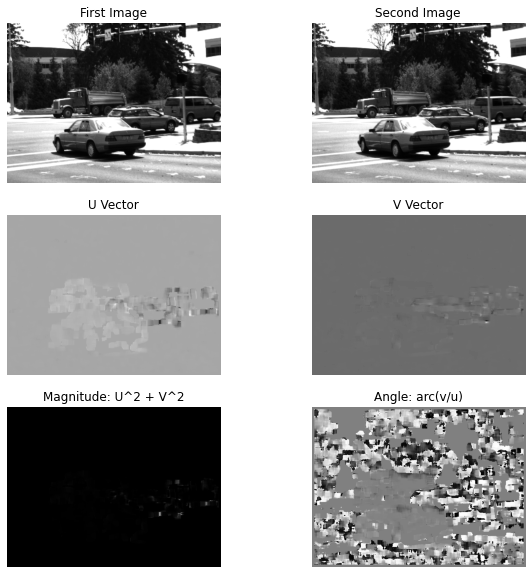

In [27]:
plot_vectors(img1g,img2g,u1,v1)

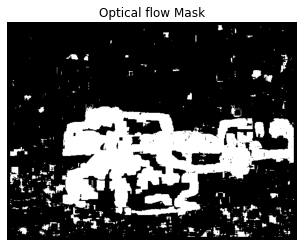

In [28]:
# 2) flow mask 시각화
# 벡터의 크기가 특정 임계값보다 큰 지 확인하고 binary segmentation을 얻음
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow( (u1*u1 + v1*v1>0.02),cmap='gray')
ax.set_title("Optical flow Mask")
ax.axis('off')
plt.show()

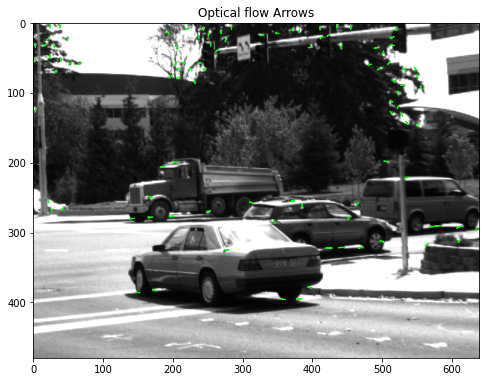

In [29]:
# 3) 이동 방향 시각화
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(img1g,cmap='gray')
ax.set_title("Optical flow Arrows")

kp = cv2.goodFeaturesToTrack(img1g, 100, 0.01, 10, 3)
for arrow_ind in kp:
    x,y = arrow_ind[0]
    y = int(y)
    x = int(x)
    ax.arrow(x,y,u1[y,x],v1[y,x],head_width = 1, head_length = 5, color = (0,1,0))
plt.show()

### 다른 이미지 결과 확인 (요약)

In [30]:
def plot_results(img1, img2, u, v):
    f = plt.figure(figsize=(10,10))

    f.add_subplot(1,2, 1)
    plt.imshow(img1)
    f.add_subplot(1,2, 2)
    plt.imshow(img2)

    # For the mask and flow arrows
    fig = plt.figure(figsize=(15,15))
    
    ax = fig.add_subplot(1,2, 1)
    ax.imshow( (u*u + v*v>0.02),cmap='gray')
    ax.set_title("Optical flow Mask")
    ax.axis('off')

    ax = fig.add_subplot(1,2, 2)
    ax.imshow(img1,cmap='gray')
    ax.set_title("Optical flow Arrows")

    kp = cv2.goodFeaturesToTrack(img1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 1, head_length = 5, color = (0,1,0))

    plt.show()

In [31]:
# Urban
img1_urban = cv2.imread('/content/drive/MyDrive/Optical-Flow/data/Urban/frame10.png')
img2_urban = cv2.imread('/content/drive/MyDrive/Optical-Flow/data/Urban/frame11.png')

# convert to grayscale
img1_urban = cv2.cvtColor(img1_urban, cv2.COLOR_BGR2GRAY)
img2_urban = cv2.cvtColor(img2_urban, cv2.COLOR_BGR2GRAY)

u4,v4 = optical_flow(img1_urban, img2_urban, 15)

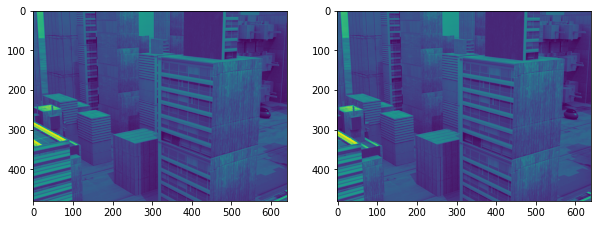

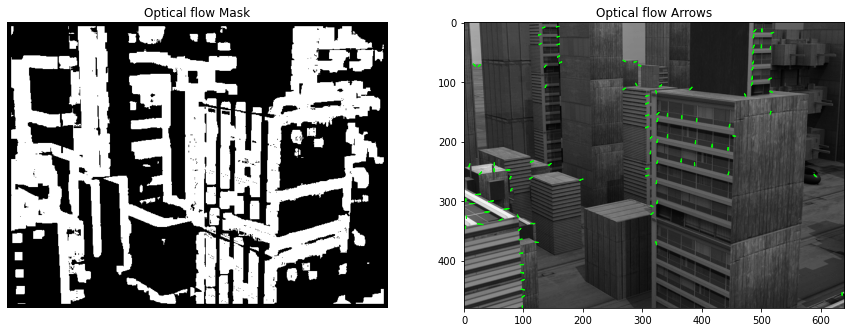

In [32]:
plot_results(img1_urban, img2_urban, u4, v4)

### 영상에서 Optical Flow - 개체 분할
- 비디오를 개별 프레임으로 분해
- 프레임별로 비디오 캡처 후 각 개별 프레임을 'frames'폴더에 저장

In [43]:
# Create a VideoCapture object 
# 0 for webcam
cap = cv2.VideoCapture('/content/drive/MyDrive/Optical-Flow/data/video2.mp4')
count = 0

if (cap.isOpened()== False): 
  print("Error")

In [10]:
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  
  if ret == True:
    name = '/content/drive/MyDrive/Optical-Flow/frames/frame' + str(count) + '.jpg'
    print ('Creating...' + name) 
    cv2.imwrite(name, frame)
    # cv2_imshow(frame)
    count+=1

    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
cap.release()
cv2.destroyAllWindows()

Creating.../content/drive/MyDrive/Optical-Flow/frames/frame0.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame1.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame2.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame3.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame4.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame5.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame6.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame7.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame8.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame9.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame10.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame11.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame12.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame13.jpg
Creating.../content/drive/MyDrive/Optical-Flow/frames/frame14.jpg
Creating.../content/

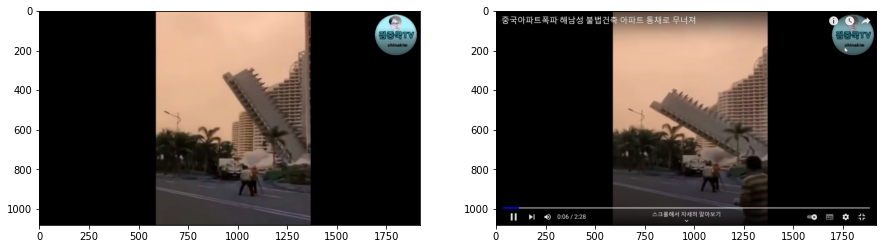

In [38]:
img1 = cv2.imread('/content/drive/MyDrive/Optical-Flow/frames/frame210.jpg')
img2 = cv2.imread('/content/drive/MyDrive/Optical-Flow/frames/frame250.jpg')
f = plt.figure(figsize=(15,15))
f.add_subplot(1,2, 1)
plt.imshow(img1)
f.add_subplot(1,2, 2)
plt.imshow(img2)

In [39]:
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
u5,v5 = optical_flow(img1, img2, 15)

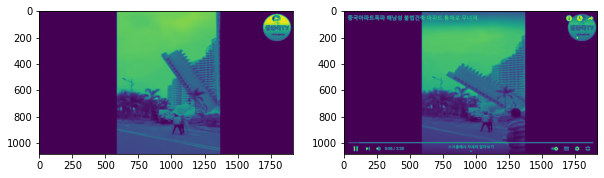

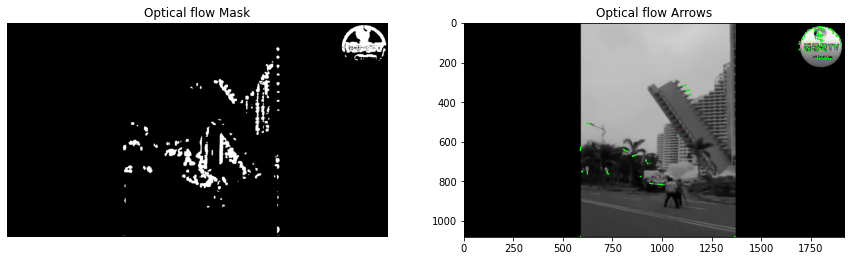

In [40]:
plot_results(img1, img2, u5, v5)

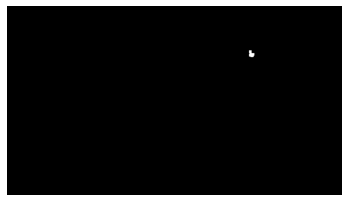

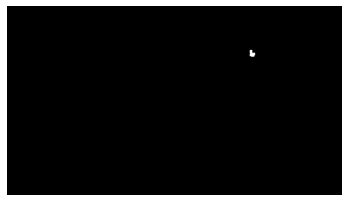

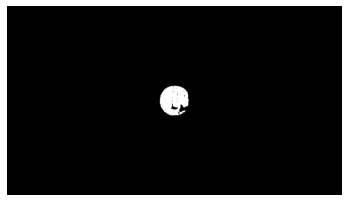

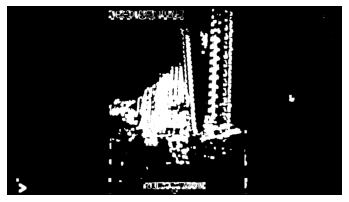

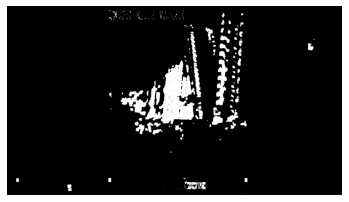

In [41]:
ctr = 1
for i in range(20,101,20):
    finalname1 = '/content/drive/MyDrive/Optical-Flow/frames/frame' + str(i) + '.jpg'
    img1 = cv2.imread(finalname1)
    finalname2 = '/content/drive/MyDrive/Optical-Flow/frames/frame' + str(i+20) + '.jpg'
    img2 = cv2.imread(finalname2)
    
    img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    u,v = optical_flow(img1g, img2g, 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    ax.imshow( (u*u + v*v>0.02),cmap='gray')
    ax.axis('off')
    
    output_name = '/content/drive/MyDrive/Optical-Flow/output-masks/mask' + str(ctr) + '.jpg'
    plt.savefig(output_name)
    ctr = ctr+1
    

### 영상에서 Optical Flow - 물체 추적
- 첫 번째 프레임에서 Shi-Tomasi 모서리 지점을 감지한 다음 lucas-kanade optical flow를 사용하여 해당 지점을 반복적으로 추적
- cv2.calcOpticalFlowPyrLK() 함수의 경우 이전 프레임, 이전 지점 및 다음 프레임을 전달
- 다음 포인트가 발견되면 값이 1이고 그렇지 않으면 0인 상태 번호와 함께 다음 포인트를 반환

In [45]:
# This code takes as input the video and performs object tracking using optical flow. 
import numpy as np
import cv2

cap = cv2.VideoCapture('/content/drive/MyDrive/Optical-Flow/data/video2.mp4')

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))


# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params) # 포인트 결정

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
ctr = 0
while(1):
    ret,frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imwrite('/content/drive/MyDrive/Optical-Flow/output-tracking/' + str(ctr) + '.jpg', img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    ctr = ctr + 1 

cv2.destroyAllWindows()
cap.release()

TypeError: ignored

In [ ]:
img1_tracking = cv2.imread('./output-tracking/75.jpg')
img2_tracking = cv2.imread('./output-tracking/164.jpg')
img3_tracking = cv2.imread('./output-tracking/254.jpg')
img4_tracking = cv2.imread('./output-tracking/331.jpg')

f = plt.figure(figsize=(20,20))
f.add_subplot(1,2, 1)
plt.axis('off')
plt.imshow(img1_tracking)

f.add_subplot(1,2, 2)
plt.axis('off')
plt.imshow(img2_tracking)

plt.show()